Prometheus 'up' query response (truncated): [{'metric': {'__name__': 'up', 'app': 'compose-post-service', 'instance': '192.168.140.44:15020', 'job': 'kubernetes-pods', 'namespace': 'social-network2', 'pod': 'compose-post-service-79fffc8f65-jn7sw', 'pod_template_hash': '79fffc8f65', 'security_istio_io_tlsMode': 'istio', 'service': 'compose-post-service', 'service_istio_io_canonical_name': 'compose-post-service', 'service_istio_io_canonical_revision': 'latest'}, 'value': [1741090802.705, '1']}, {'metric': {'__name__': 'up', 'app': 'compose-post-service', 'instance': '192.168.18.220:15020', 'job': 'kubernetes-pods', 'namespace': 'social-network3', 'pod': 'compose-post-service-79fffc8f65-4j455', 'pod_template_hash': '79fffc8f65', 'security_istio_io_tlsMode': 'istio', 'service': 'compose-post-service', 'service_istio_io_canonical_name': 'compose-post-service', 'service_istio_io_canonical_revision': 'latest'}, 'value': [1741090802.705, '1']}, {'metric': {'__name__': 'up', 'app': 'compose-pos

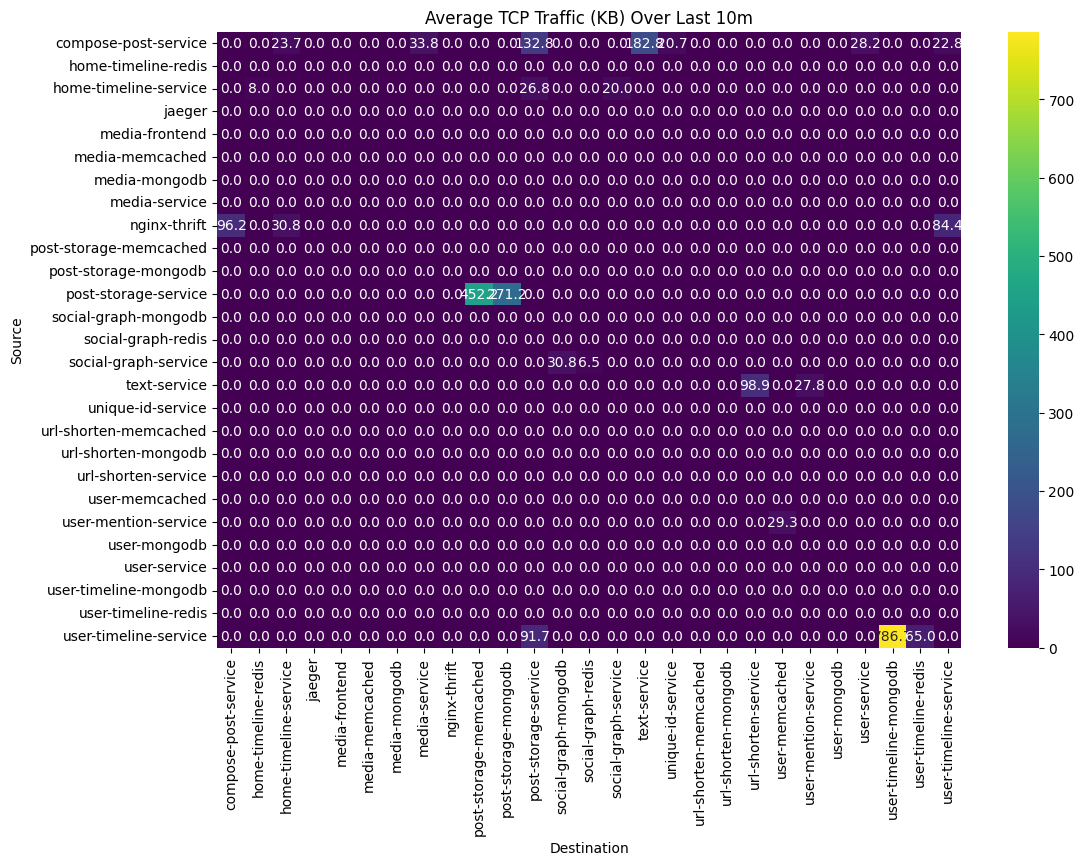

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from datetime import datetime, timedelta
from kubernetes import client, config
from prometheus_api_client import PrometheusConnect

import networkx as nx

# 1. Kubernetes Config
config.load_kube_config()
v1 = client.CoreV1Api()

# 2. Prometheus Config
prom_url = "http://10.105.116.175:9090"
prom = PrometheusConnect(url=prom_url, disable_ssl=True)

# Test Prometheus connection
prom_connect_response = prom.custom_query(query="up")
print("Prometheus 'up' query response (truncated):", prom_connect_response[:3])

def get_ready_deployments(namespace):
    """
    Returns a list of deployment names in the given namespace
    where all replicas are ready.
    """
    ready_deployments = []
    apps_api = client.AppsV1Api()
    deployments = apps_api.list_namespaced_deployment(namespace)
    for d in deployments.items:
        spec_replicas = d.spec.replicas or 0
        ready_replicas = d.status.ready_replicas or 0
        if ready_replicas == spec_replicas and spec_replicas > 0:
            ready_deployments.append(d.metadata.name)
    return ready_deployments

def transmitted_req_calculator(workload_src, workload_dst, timerange, step_interval, app_namespace):
    """
    Queries Prometheus for istio_tcp_sent_bytes_total and istio_tcp_received_bytes_total
    from workload_src -> workload_dst, calculates an average traffic rate (in bytes)
    over the specified time range.
    Returns an integer representing the average traffic (bytes), or 0 if no data.
    """
    end_time = datetime.now()
    start_time = end_time - timedelta(minutes=timerange)

    query_sent = (
        f'istio_tcp_sent_bytes_total{{reporter="source",'
        f'source_workload="{workload_src}",'
        f'destination_workload="{workload_dst}",'
        f'namespace="{app_namespace}"}}'
    )
    query_recv = (
        f'istio_tcp_received_bytes_total{{reporter="source",'
        f'source_workload="{workload_src}",'
        f'destination_workload="{workload_dst}",'
        f'namespace="{app_namespace}"}}'
    )

    sent_data = prom.custom_query_range(
        query=query_sent,
        start_time=start_time,
        end_time=end_time,
        step=step_interval
    )
    recv_data = prom.custom_query_range(
        query=query_recv,
        start_time=start_time,
        end_time=end_time,
        step=step_interval
    )

    # If there's no data for either metric, return 0
    if (not sent_data or not sent_data[0]['values']) and (not recv_data or not recv_data[0]['values']):
        return 0

    try:
        values_sent = sent_data[0]['values']
        values_recv = recv_data[0]['values']

        # The first entry and last entry in each time series
        _, begin_sent_counter = values_sent[0]
        _, end_sent_counter = values_sent[-1]

        _, begin_recv_counter = values_recv[0]
        _, end_recv_counter = values_recv[-1]

        data_points_num_sent = len(values_sent)
        data_points_num_recv = len(values_recv)

        avg_sent = (float(end_sent_counter) - float(begin_sent_counter)) / data_points_num_sent
        avg_recv = (float(end_recv_counter) - float(begin_recv_counter)) / data_points_num_recv

        average_traffic_bytes = int((avg_sent + avg_recv) / 2)
        print(f"from {workload_src} to {workload_dst} ~ {average_traffic_bytes/1000:.1f} KB")
        return average_traffic_bytes
    except (IndexError, ValueError, KeyError) as e:
        print(f"Error processing data from {workload_src} to {workload_dst}: {e}")
        return 0

# 3. Specify your namespace and get the list of "ready" deployments
namespace = "social-network"
ready_deployments = get_ready_deployments(namespace)
print("Ready Deployments:", ready_deployments)

# 4. Build a traffic matrix (DataFrame) for these deployments
df_exec_graph = pd.DataFrame(index=ready_deployments, columns=ready_deployments, data=0.0)

for src in ready_deployments:
    for dst in ready_deployments:
        if src != dst:
            avg_bytes = transmitted_req_calculator(
                workload_src=src,
                workload_dst=dst,
                timerange=10,       # Look back 10 minutes
                step_interval="1m", # Step = 1 minute
                app_namespace=namespace
            )
            df_exec_graph.at[src, dst] = avg_bytes / 1000.0  # store as KB

print("\nTraffic Matrix (KB):")
print(df_exec_graph)

# 5. Visualize as a Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df_exec_graph, cmap='viridis', annot=True, fmt=".1f")
plt.title("Average TCP Traffic (KB) Over Last 10m")
plt.xlabel("Destination")
plt.ylabel("Source")
plt.show()

# 6. Build a Directed Graph with NetworkX
G = nx.DiGraph()

# Add nodes for each deployment
for deployment in ready_deployments:
    G.add_node(deployment)

# Add edges where traffic > 0
for src in ready_deployments:
    for dst in ready_deployments:
        weight_kb = df_exec_graph.at[src, dst]
        if weight_kb > 0:
            G.add_edge(src, dst, weight=weight_kb)



/tmp/ipykernel_2292516/1744162619.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("tab20", num_nodes)


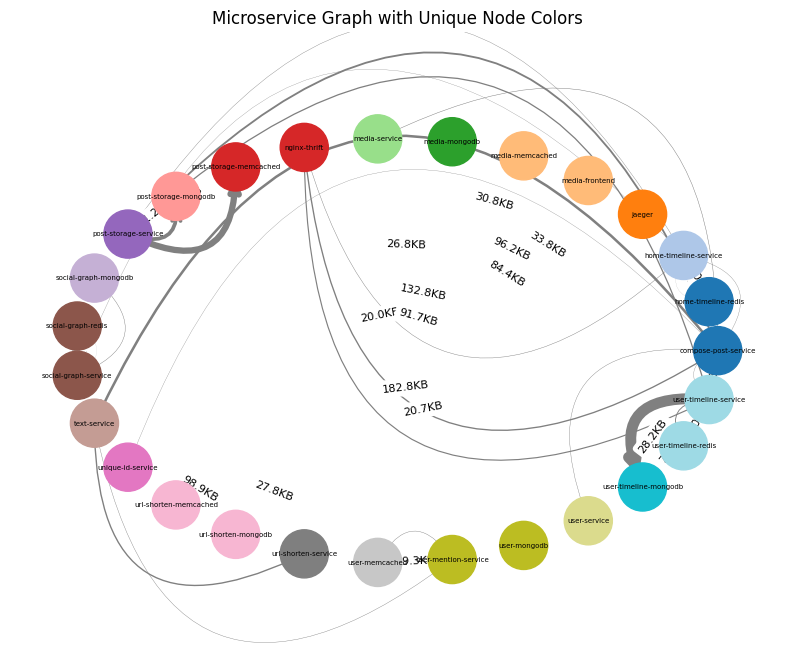

In [32]:
# 7. Draw the Graph
# pos = nx.spring_layout(G, k=0.8)  # Force-directed layout
pos = nx.circular_layout(G, scale=2.0)  # <-- changed to a circular layout
# pos = nx.shell_layout(G) #`shell_layout` is another option for a circular layout
# pos =nx.planar_layout(G, scale=5, dim=2) #



plt.figure(figsize=(10, 8))

# Generate a unique color for each node
nodes = list(G.nodes())
num_nodes = len(nodes)
# Use a colormap with enough distinct colors; e.g., "tab20"
cmap = plt.cm.get_cmap("tab20", num_nodes)
node_colors = [cmap(i) for i in range(num_nodes)]

# Draw nodes with individual colors
nx.draw_networkx_nodes(G, pos, nodelist=nodes, node_color=node_colors, node_size=1200)

# Do not draw node labels (or comment out the following line if you want to hide them)
nx.draw_networkx_labels(G, pos, font_size=5)

# Draw edges with arrow style
edges = G.edges(data=True)
edge_weights = [e[2]['weight'] for e in edges]
nx.draw_networkx_edges(
    G, pos,
    arrowstyle="->",
    arrowsize=15,
    width=[w/100 for w in edge_weights],  # adjust scaling as needed
    edge_color="gray",
    connectionstyle="arc3,rad=0.8" ## <--- add curvature to edges
)

# Optionally, label edges with traffic values
edge_labels = {(u, v): f"{d['weight']:.1f}KB" for u, v, d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

plt.title("Social Network Microservice Graph with Average Traffic (KB)")
plt.axis("off")
plt.show()
